# Todo

## MAGIC dataset
* kNN
* LR(?)
* NN using tensorflow
* XGBoost
* PCA
* Rerun methods
* Write report comparing methods and discussing importance of PCA for ten features (19020 datapoints) where some have correlation

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.neighbors as sklne
import sklearn.model_selection as sklms
import sklearn.preprocessing as sklpre
import tensorflow as tf
import seaborn as sns
import scikitplot as sklplt
import sklearn.metrics as sklme
import tensorflow_addons as tfa
import xgboost as xgb
import sklearn.decomposition as sklde
import skopt
import joblib

fonts = {
    "font.family": "serif",
    "axes.labelsize": 10,
    "font.size": 10,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
}

plt.rcParams.update(fonts)

np.random.seed(123)

<IPython.core.display.Javascript object>

In [8]:
# Black for Jupyter Notebook!
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

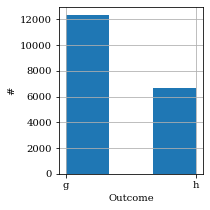

<IPython.core.display.Javascript object>

In [70]:
# Reading data
df = pd.read_csv("data/telescope_data.csv")
# Dropping useless column
df.drop("Unnamed: 0", axis=1, inplace=True)
# Setting feature matrix X and outcome y
X = df.drop("class", axis=1)
y = df["class"]

# Splitting
X_train, X_test, y_train, y_test = sklms.train_test_split(
    X, y, stratify=y, test_size=0.33
)

# Scaling feature matrix (All features are scalar).
scaler = sklpre.StandardScaler()

X_train = pd.DataFrame(
    scaler.fit_transform(X_train.to_numpy()), columns=X_train.columns
)
X_test = pd.DataFrame(scaler.transform(X_test.to_numpy()), columns=X_test.columns)

# One-hot encoding outcomes, keeping them as dataframes
encoder = sklpre.OneHotEncoder(categories="auto", sparse=False)
# Plotting histogram of outcomes
fig, ax = plt.subplots(figsize=(3.01682, 3.01682))
y.hist(ax=ax, density=False, bins=3)

y_train = pd.DataFrame(
    encoder.fit_transform(y_train.to_numpy().reshape(-1, 1)),
    columns=encoder.categories_,
)
y_test = pd.DataFrame(
    encoder.fit_transform(y_test.to_numpy().reshape(-1, 1)),
    columns=encoder.categories_,
)
ax.set_xlabel("Outcome")
ax.set_ylabel("#")
fig.tight_layout()
fig.savefig("../doc/figures/histogram.pdf", dpi=1000)
plt.show()
# Deleting non-used objects to avoid bugs later and save memory
del X
del y
del df

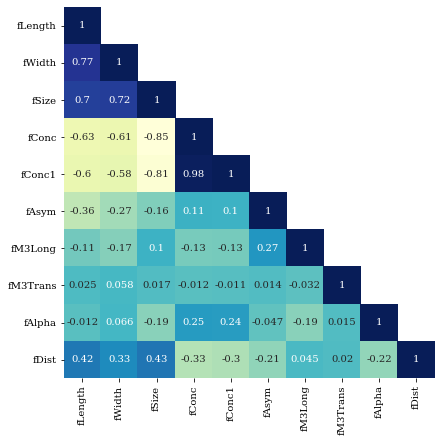

<IPython.core.display.Javascript object>

In [63]:
# Plotting correlation matrix
fig, ax = plt.subplots(figsize=(6.24123, 6.24123))
X_train_corr = X_train.corr()
mask = np.triu(X_train_corr, k=1)
mask = np.ma.array(X_train_corr.to_numpy(), mask=mask)
X_train_corr = pd.DataFrame(
    mask, columns=X_train_corr.columns, index=X_train_corr.index,
)
sns.heatmap(X_train_corr, cmap="YlGnBu", ax=ax, square=True, annot=True, cbar=False)
ax.set_ylim([10, 0])
ax.set_xlim([0, 10])
fig.tight_layout()
fig.savefig("../doc/figures/correlation_matrix_train.pdf", dpi=1000)
plt.show()

# kNN

In [12]:
knn_base = sklne.KNeighborsClassifier()

hyperparams_knn = {"n_neighbors": np.arange(1, 50)}
# As we saw in the earlier plot, we have an imbalanced dataset. Therefore we use the F1 score instead of accuracy
grid_search_knn = sklms.GridSearchCV(
    knn_base,
    hyperparams_knn,
    scoring="f1_weighted",
    cv=5,
    iid=False,
    n_jobs=-1,
    verbose=0,
).fit(X_train, y_train)

<IPython.core.display.Javascript object>

k-NN:
Train weighted f1 score: 0.88
Test weighted f1 score: 0.83
Best k = 5


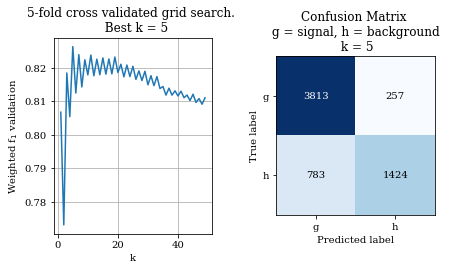

<IPython.core.display.Javascript object>

In [13]:
print("k-NN:")
print(f"Train weighted f1 score: {grid_search_knn.score(X_train, y_train):.2f}")
print(f"Test weighted f1 score: {grid_search_knn.score(X_test, y_test):.2f}")
print(f"Best k = {grid_search_knn.best_params_['n_neighbors']}")
fig, ax = plt.subplots(1, 2, figsize=[6.24123, 6.24123 / 1.618])
y_pred_test = encoder.inverse_transform(grid_search_knn.predict(X_test))
sklplt.metrics.plot_confusion_matrix(
    encoder.inverse_transform(y_test.to_numpy()),
    y_pred_test,
    ax=ax[1],
    hide_counts=False,
    normalize=False,
    title=f"Confusion Matrix "
    + f"\n g = signal, h = background "
    + f"\n k = {grid_search_knn.best_params_['n_neighbors']}",
)
# Scikit-plot doesn't let you disable colorbar, removing it manually
im = ax[1].images
cb = im[-1].colorbar
cb.remove()
ax[1].set_ylim([1.5, -0.5])
ax[1].set_xlim([-0.5, 1.5])
ax[0].plot(
    hyperparams_knn["n_neighbors"], grid_search_knn.cv_results_["mean_test_score"]
)
ax[0].set_xlabel("k")
ax[0].set_ylabel(r"Weighted f$_1$ validation")
ax[0].grid()
ax[0].set_title(
    f"5-fold cross validated grid search. \n  Best k = {grid_search_knn.best_params_['n_neighbors']}"
)
# fig.suptitle(fr"k Nearest Neighbors.")

fig.tight_layout()  # (rect=[0, 0.03, 1, 0.95])
fig.savefig("../doc/figures/kNN_cv_results.pdf", dpi=1000)
plt.show()

# Tensorflow neural network
## Setting hyperparameters based on validation f1

In [14]:
X_train_split, X_validation, y_train_split, y_validation = sklms.train_test_split(
    X_train, y_train, test_size=0.1, stratify=y_train
)
X_train_split = X_train_split.to_numpy()
X_validation = X_validation.to_numpy()

y_train_split = y_train_split.to_numpy()

y_validation = y_validation.to_numpy()

<IPython.core.display.Javascript object>

In [16]:
batch_sizes = skopt.space.Integer(low=1, high=200, name="batch_size")
dropout_1 = skopt.space.Real(low=0, high=0.5, name="dropout_1")
dropout_2 = skopt.space.Real(low=0, high=0.5, name="dropout_2")
nodes_1 = skopt.space.Integer(low=1, high=20, name="nodes_1")
nodes_2 = skopt.space.Integer(low=1, high=10, name="nodes_2")
space = [batch_sizes, dropout_1, dropout_2, nodes_1, nodes_2]


@skopt.utils.use_named_args(dimensions=space)
def neural_network_fit(
    batch_size, dropout_1, dropout_2, nodes_1, nodes_2, return_epochs=False
):
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=3, verbose=1, restore_best_weights=True
    )
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Dense(nodes_1, activation="relu"),
            tf.keras.layers.Dropout(dropout_1),
            tf.keras.layers.Dense(nodes_2, activation="relu"),
            tf.keras.layers.Dropout(dropout_2),
            tf.keras.layers.Dense(2, activation="softmax"),
        ]
    )
    model.compile(
        optimizer="adam", loss="categorical_crossentropy",
    )

    model.fit(
        X_train_split,
        y_train_split,
        epochs=100,
        batch_size=batch_size,
        validation_data=(X_validation, y_validation),
        verbose=0,
        callbacks=[early_stop],
    )
    if return_epochs:
        print("jeff")
        return early_stop.stopped_epoch
    y_pred_validation_nn = model.predict_classes(X_validation).reshape(-1, 1)
    y_pred_validation_nn = np.append(
        y_pred_validation_nn == 0, y_pred_validation_nn == 1, axis=1
    ).astype(np.int)
    f1_score_weighted_validation = sklme.f1_score(
        y_true=y_validation, y_pred=y_pred_validation_nn, average="weighted"
    )

    return 1 - f1_score_weighted_validation


n_points = 10
optimizer_nn = skopt.gp_minimize(
    func=neural_network_fit,
    dimensions=space,
    n_jobs=1,
    verbose=True,
    n_calls=n_points,
    n_random_starts=n_points,
)

Iteration No: 1 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 7.2298
Function value obtained: 0.2104
Current minimum: 0.2104
Iteration No: 2 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 6.0830
Function value obtained: 0.1578
Current minimum: 0.1578
Iteration No: 3 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 11.0489
Function value obtained: 0.1595
Current minimum: 0.1578
Iteration No: 4 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00017: early stopping
Iteration No: 4 ended.

<IPython.core.display.Javascript object>

## Refitting on full training set

In [17]:
best_batch_nn = optimizer_nn["x"][0]
best_dropout_1 = optimizer_nn["x"][1]
best_dropout_2 = optimizer_nn["x"][2]
best_nodes_1 = optimizer_nn["x"][3]
best_nodes_2 = optimizer_nn["x"][4]
print(
    type(best_batch_nn),
    type(best_dropout_1),
    best_dropout_2,
    type(best_nodes_1),
    best_nodes_2,
)
best_epochs = neural_network_fit.__wrapped__(
    best_batch_nn, best_dropout_1, best_dropout_2, best_nodes_1, best_nodes_2, True,
)
print(best_epochs)
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(best_nodes_1, activation="relu"),
        tf.keras.layers.Dropout(best_dropout_1),
        tf.keras.layers.Dense(best_nodes_2, activation="relu"),
        tf.keras.layers.Dropout(best_dropout_2),
        tf.keras.layers.Dense(2, activation="softmax"),
    ]
)
model.compile(
    optimizer="adam", loss="categorical_crossentropy",
)

model.fit(
    X_train.to_numpy(),
    y_train.to_numpy(),
    epochs=best_epochs,
    batch_size=best_batch_nn,
    verbose=1,
)
model.save_weights("models/best_nn_not_pca")
np.save("models/best_hyperparams_nn.npy", optimizer_nn["x"])

<class 'numpy.int64'> <class 'numpy.float64'> 0.06468092229096302 <class 'numpy.int64'> 5
Restoring model weights from the end of the best epoch.
Epoch 00059: early stopping
jeff
58
Train on 12743 samples
Epoch 1/58
12743/12743 [==============================] - 1s 90us/sample - loss: 0.6423
Epoch 2/58
12743/12743 [==============================] - 0s 16us/sample - loss: 0.5411
Epoch 3/58
12743/12743 [==============================] - 0s 13us/sample - loss: 0.4822
Epoch 4/58
12743/12743 [==============================] - 0s 12us/sample - loss: 0.4574
Epoch 5/58
12743/12743 [==============================] - 0s 13us/sample - loss: 0.4435
Epoch 6/58
12743/12743 [==============================] - 0s 12us/sample - loss: 0.4292
Epoch 7/58
12743/12743 [==============================] - 0s 15us/sample - loss: 0.4206
Epoch 8/58
12743/12743 [==============================] - 0s 18us/sample - loss: 0.4119
Epoch 9/58
12743/12743 [==============================] - 0s 13us/sample - loss: 0.4049
Epo

<IPython.core.display.Javascript object>

Neural Network:
Train weighted f1 score: 0.87
Test weighted f1 score: 0.87
Best hyperparams: [1.75000000e+02 1.18285357e-01 6.46809223e-02 1.60000000e+01
 5.00000000e+00]


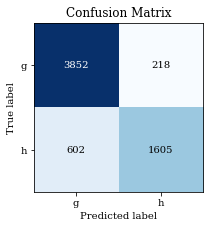

<IPython.core.display.Javascript object>

In [18]:
best_hyperparams = np.load("models/best_hyperparams_nn.npy")
best_batch_nn = best_hyperparams[0]
best_dropout_1 = best_hyperparams[1]
best_dropout_2 = best_hyperparams[2]
best_nodes_1 = best_hyperparams[3]
best_nodes_2 = best_hyperparams[4]

model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(best_nodes_1, activation="relu"),
        tf.keras.layers.Dropout(best_dropout_1),
        tf.keras.layers.Dense(best_nodes_2, activation="relu"),
        tf.keras.layers.Dropout(best_dropout_2),
        tf.keras.layers.Dense(2, activation="softmax"),
    ]
)
model.compile(
    optimizer="adam", loss="categorical_crossentropy",
)
model.load_weights("models/best_nn_not_pca")

y_pred_train_nn = model.predict_classes(X_train.to_numpy()).reshape(-1, 1)
y_pred_train_nn = np.append(y_pred_train_nn == 0, y_pred_train_nn == 1, axis=1).astype(
    np.int
)

y_pred_test_nn = model.predict_classes(X_test.to_numpy()).reshape(-1, 1)
y_pred_test_nn = np.append(y_pred_test_nn == 0, y_pred_test_nn == 1, axis=1).astype(
    np.int
)

f1_score_weighted_train = sklme.f1_score(
    y_true=y_train, y_pred=y_pred_train_nn, average="weighted"
)

f1_score_weighted_test = sklme.f1_score(
    y_true=y_test, y_pred=y_pred_test_nn, average="weighted"
)


print("Neural Network:")
print(f"Train weighted f1 score: {f1_score_weighted_train:.2f}")
print(f"Test weighted f1 score: {f1_score_weighted_test:.2f}")
print(f"Best hyperparams: {best_hyperparams}")

fig, ax = plt.subplots(figsize=[3.01682, 3.01682])
sklplt.metrics.plot_confusion_matrix(
    encoder.inverse_transform(y_test.to_numpy()),
    encoder.inverse_transform(y_pred_test_nn),
    ax=ax,
)
ax.set_ylim([1.5, -0.5])
ax.set_xlim([-0.5, 1.5])
im = ax.images
cb = im[-1].colorbar
cb.remove()
fig.tight_layout()
fig.savefig("../doc/figures/nn_confusion_matrix.pdf", dpi=1000)
plt.show()

# XGBoost

In [19]:
y_train_boost = encoder.inverse_transform(y_train).ravel()
y_test_boost = encoder.inverse_transform(y_test).ravel()

y_train_split_boost = encoder.inverse_transform(y_train_split).ravel()
y_validation_boost = encoder.inverse_transform(y_validation).ravel()

validation_set_boost = [(X_validation, y_validation_boost)]

<IPython.core.display.Javascript object>

In [20]:
space_xg = [
    skopt.space.Real(low=1e-2, high=2e-1, prior="log-uniform", name="learning_rate"),
    skopt.space.Integer(low=1, high=10, name="max_tree_depth"),
    skopt.space.Real(low=1e-3, high=1e-1, prior="log-uniform", name="l1_alpha"),
    skopt.space.Real(low=1e-3, high=1e-1, prior="log-uniform", name="l2_lambda"),
    skopt.space.Integer(low=1, high=10, name="min_child_weight"),
]

<IPython.core.display.Javascript object>

In [21]:
@skopt.utils.use_named_args(dimensions=space_xg)
def xgboost_tune(
    learning_rate,
    max_tree_depth,
    l1_alpha,
    l2_lambda,
    min_child_weight,
    return_estimators=False,
):

    xgboost = xgb.XGBClassifier(
        objective="binary:logistic",
        n_jobs=-1,
        n_estimators=int(1e3),
        learning_rate=learning_rate,
        max_depth=max_tree_depth,
        reg_alpha=l1_alpha,
        reg_lambda=l2_lambda,
        min_child_weight=min_child_weight,
    ).fit(
        X=X_train_split,
        y=y_train_split_boost,
        eval_metric=["logloss"],
        eval_set=validation_set_boost,
        early_stopping_rounds=3,
        verbose=False,
    )

    y_pred_validation_boost = xgboost.predict(X_validation).reshape(-1, 1)
    f1_score_validation = sklme.f1_score(
        y_true=y_validation,
        y_pred=encoder.transform(y_pred_validation_boost),
        average="weighted",
    )

    if return_estimators:
        return xgboost.best_iteration

    return 1 - f1_score_validation

<IPython.core.display.Javascript object>

In [23]:
n_points_xg = 10
optimizer_xgboost = skopt.gp_minimize(
    func=xgboost_tune,
    dimensions=space_xg,
    n_jobs=1,
    verbose=True,
    n_calls=n_points_xg,
    n_random_starts=n_points_xg,
)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.6137
Function value obtained: 0.1262
Current minimum: 0.1262
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 6.6790
Function value obtained: 0.1367
Current minimum: 0.1262
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 6.4416
Function value obtained: 0.1515
Current minimum: 0.1262
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 7.9325
Function value obtained: 0.1295
Current minimum: 0.1262
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1.4966
Function value obtained: 0.1250
Current minimum: 0.1250
Iteration No: 6 started. Evaluating

<IPython.core.display.Javascript object>

In [24]:
(
    best_learning_rate,
    best_max_tree_depth,
    best_l1_alpha,
    best_l2_lambda,
    best_min_child_weight,
) = optimizer_xgboost["x"]

print(
    best_learning_rate,
    best_max_tree_depth,
    best_l1_alpha,
    best_l2_lambda,
    best_min_child_weight,
)

best_n_estimators = xgboost_tune.__wrapped__(
    best_learning_rate,
    best_max_tree_depth,
    best_l1_alpha,
    best_l2_lambda,
    best_min_child_weight,
    return_estimators=True,
)
print(best_n_estimators)

0.032839820131919696 9 0.034892374484021674 0.002483502747194566 8
187


<IPython.core.display.Javascript object>

In [43]:
xgboost_refit = xgb.XGBClassifier(
    objective="binary:logistic",
    n_jobs=-1,
    n_estimators=best_n_estimators,
    learning_rate=best_learning_rate,
    max_depth=best_max_tree_depth,
    reg_alpha=best_l1_alpha,
    reg_lambda=best_l2_lambda,
    min_child_weight=best_min_child_weight,
    verbose=True,
).fit(X_train, y_train_boost)

joblib.dump(xgboost_refit, "models/xgboost_refit.pkl")
np.save(
    "models/best_hyperparams_xgboost.npy",
    np.array(optimizer_xgboost["x"], dtype=object),
)

<IPython.core.display.Javascript object>

In [44]:
best_hyperparams_xgboost = dict(
    zip(
        ["learning_rate", "max_depth", "reg_alpha", "reg_lambda", "min_child_weight",],
        np.load("models/best_hyperparams_xgboost.npy", allow_pickle=True),
    )
)
xgboost_refit = joblib.load("models/xgboost_refit.pkl")

<IPython.core.display.Javascript object>

XGBoost:
Train weighted f1 score: 0.92
Test weighted f1 score: 0.88


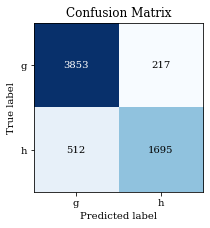

<IPython.core.display.Javascript object>

In [45]:
y_pred_train_boost = xgboost_refit.predict(X_train).reshape(-1, 1)
y_pred_test_boost = xgboost_refit.predict(X_test).reshape(-1, 1)

f1_score_weighted_train_boost = sklme.f1_score(
    y_true=y_train, y_pred=encoder.transform(y_pred_train_boost), average="weighted"
)

f1_score_weighted_test_boost = sklme.f1_score(
    y_true=y_test, y_pred=encoder.transform(y_pred_test_boost), average="weighted"
)

print("XGBoost:")
print(f"Train weighted f1 score: {f1_score_weighted_train_boost:.2f}")
print(f"Test weighted f1 score: {f1_score_weighted_test_boost:.2f}")


fig, ax = plt.subplots(figsize=[3.01682, 3.01682])
sklplt.metrics.plot_confusion_matrix(
    encoder.inverse_transform(y_test.to_numpy()), y_pred_test_boost, ax=ax,
)

ax.set_ylim([1.5, -0.5])
ax.set_xlim([-0.5, 1.5])
im = ax.images
cb = im[-1].colorbar
cb.remove()
fig.tight_layout()
fig.savefig("../doc/figures/xgboost_confusion_matrix.pdf", dpi=1000)
plt.show()

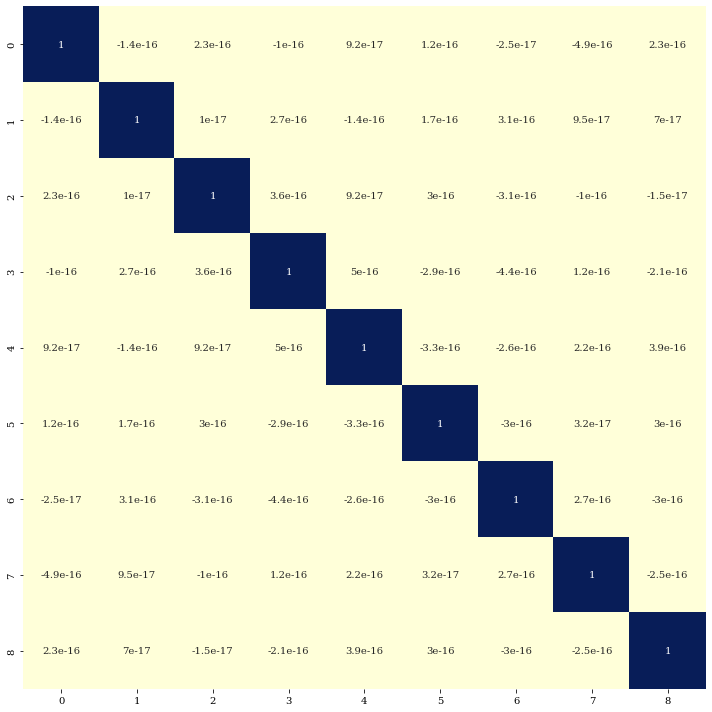

<IPython.core.display.Javascript object>

In [46]:
pca = sklde.PCA(n_components="mle")
X_train_pca = pd.DataFrame(pca.fit_transform(X_train))
X_test_pca = pd.DataFrame(pca.transform(X_test))
fig, ax = plt.subplots(figsize=(10 * 1.618, 10))
sns.heatmap(
    X_train_pca.corr(), cmap="YlGnBu", ax=ax, square=True, annot=True, cbar=False
)
ax.set_ylim([9, 0])
ax.set_xlim([0, 9])
fig.tight_layout()
plt.show()